# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 2: Linear and k-NN Regression


**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">


In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Restart the kernel and run the whole notebook again before you submit. 
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed.

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

## <div class="theme">  <b>Predicting Taxi Pickups in NYC</b> </div>

In this homework, we will explore k-nearest neighbor and linear regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in the file `nyc_taxi.csv`.  You will need to separate it into training and test sets. The first column contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded in NYC during Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pickups at that time. The models will be fitted to the training set and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric.

### <div class="exercise"> <b> Question 1  [20 pts]</b> </div>

**1.1**. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 42 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.

**1.2**. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is dependent on the time of the day.  Be sure to title your plot.

**1.3**. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result. 

**1.4**. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly surmise why this may be the case.  This will not be graded harshly, we just want you to think and communicate about the cause.


### Answers

**1.1 Use pandas to load the dataset from the csv file ...**

In [3]:
# read the file
# your code here
df = pd.read_csv("data/nyc_taxi.csv")
df.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [4]:
# split the data
# your code here
#set random_state to get the same split every time
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

**1.2 Generate a scatter plot of the training data points**


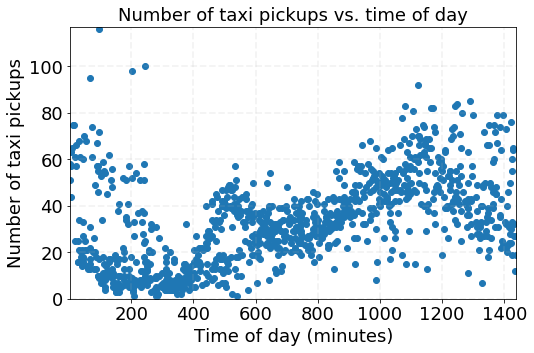

In [5]:
# Your code here
# from lab 3

def nice_scatterplot(x, y, title):
    # font size
    f_size = 18
    
    # make the figure
    fig, ax = plt.subplots(1,1, figsize=(8,5)) # Create figure object

    # set axes limits to make the scale nice
    ax.set_xlim(np.min(x)-1, np.max(x) + 1)
    ax.set_ylim(np.min(y)-1, np.max(y) + 1)

    # adjust size of tickmarks in axes
    ax.tick_params(labelsize = f_size)
    
    # remove tick labels
    #ax.tick_params(labelbottom=False,  bottom=False)
    
    # adjust size of axis label
    ax.set_xlabel('Time of day (minutes)', fontsize = f_size)
    ax.set_ylabel('Number of taxi pickups', fontsize = f_size)
    
    # set figure title label
    ax.set_title(title, fontsize = f_size)

    # you may set up grid with this 
    ax.grid(True, lw=1.75, ls='--', alpha=0.15)

    # make actual plot (Notice the label argument!)
    #ax.scatter(x, y, label=r'$my points$')
    #ax.scatter(x, y, label='$my points$')
    ax.scatter(x, y)#,label=r'$my\,points$')
    #ax.legend(loc='best', fontsize = f_size);
    
    return ax

nice_scatterplot(train_data.TimeMin, train_data.PickupCount, 'Number of taxi pickups vs. time of day')


**1.3 In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result.**

The number of taxi pickups fluctuates throughout the day. Until 200 minutes into the day, there is a relatively high number of taxi pickups perhaps due to morning commutes. WHAT TIME OF DAY IS 200 MIN?? There is another peak in taxi pickups around 1200 minutes, which may correspond to the evening commute home from work. It is reasonable to see these two peaks due to traffic patterns of commuters for work.


**1.4 You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes...**

It is possible that at time 500-550 minutes, some of the taxi drivers go on a lunch break and therefore the number of taxi pickups drops to 20-30 rides. Any taxi drivers that remain on shift (not taking lunch) do more pick ups during this time to account for the shortage of workers, and this is why we see a split of some drivers doing 20-30 rides and others doing closer to 50-60 rides.


<hr>

### <div class="exercise"> <b>Question 2 [25 pts]</b> </div>

In lecture we've seen k-Nearest Neighbors (k-NN) Regression, a non-parametric regression technique.  In the following problems please use built in functionality from `sklearn` to run k-NN Regression. 


**2.1**. Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`). 

**2.2**.  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

**Hints**:
1. Each subplot should use different color and/or markers to distinguish k-NN regression prediction values from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**2.3**. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).

**2.4**. Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.

**2.5**. Discuss the results:

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?
6. Use the plots of the predictions (in 2.2) to justify why your choice of the best $k$ makes sense (**Hint**: think Goldilocks).

### Answers

**2.1 Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary...** 

In [6]:
#np.shape(train_data.TimeMin)
x_train = np.array(train_data.TimeMin)
x_train = x_train.reshape(x_train.shape[0], 1)

In [7]:
y_train = train_data.PickupCount
y_train_reshape = train_data[['PickupCount']]

In [8]:
regdict = {}
# Do a bunch of KNN regressions
k_list = [1,10,75,250,500,750,1000]
for k in k_list:
    knnreg = KNeighborsRegressor(n_neighbors=k)
    knnreg.fit(x_train, y_train)
    regdict[k] = knnreg # Store the regressors in a dictionary

In [9]:
regdict

{1: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'),
 10: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform'),
 75: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=75, p=2,
                     weights='uniform'),
 250: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=250, p=2,
                     weights='uniform'),
 500: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=500, p=2,
                     weights='uniform'),
 750: KNeighborsRegressor(algorit

**2.2  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set...**

For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

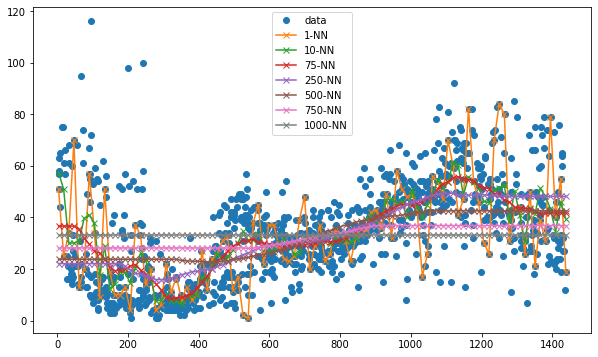

In [10]:
# training data
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(train_data.TimeMin, train_data.PickupCount, 'o', label="data")

xgrid = np.linspace(np.min(train_data.TimeMin), np.max(train_data.TimeMin), 100)
for k in k_list:
    predictions = regdict[k].predict(xgrid.reshape(100,1))
    if k in k_list:
        ax.plot(xgrid, predictions, label="{}-NN".format(k), marker='x')

ax.legend()

NameError: name 'results' is not defined

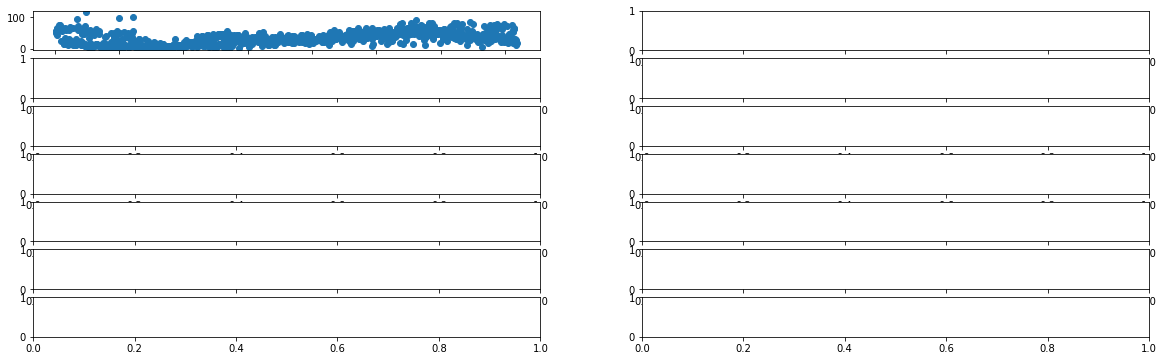

In [11]:
# Now let's plot it all
fig, axes = plt.subplots(7,2,figsize=(20,6))
axes = axes.ravel()


xgrid = np.linspace(np.min(train_data.TimeMin), np.max(train_data.TimeMin), 100)
for k in k_list:
    predictions = regdict[k].predict(xgrid.reshape(100,1))
    if k in k_list:
        ax.plot(xgrid, predictions, label="{}-NN".format(k), marker='x')

ax.legend()


axes[0].plot(train_data.TimeMin, train_data.PickupCount, 'o', label="data")
sorted_time = train_data.sort_values(['TimeMin'])
prediction_lr = results.predict(sm.add_constant(sorted_time[['TimeMin']]))
axes[0].plot(sorted_time['TimeMin'], prediction_lr, '*-', label = 'Prediction')
axes[0].set_title('Taxi pick ups vs time: Linear regression for training set')

axes[1].plot(x_test, y_test, 'o')
sorted_time = test_data.sort_values(['TimeMin'])
prediction_lr = results.predict(sm.add_constant(sorted_time[['TimeMin']]))
axes[1].plot(sorted_time['TimeMin'], prediction_lr, '*-', label = 'Prediction')
axes[1].set_title('Taxi pick ups vs time: Linear regression for test set')

for i, ax in enumerate(axes):
#    ax.set_ylim(0,10000)
    ax.set_xlabel('Time of day (in minutes)')
    ax.set_ylabel('Number of taxi pick ups')
    ax.legend()
plt.suptitle('Number of taxi pickups over time in a day',fontsize=16)

In [ ]:
# Plotting our model
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes = axes.ravel()



In [ ]:
test_data.shape
x_test = np.array(test_data.TimeMin)
x_test = x_test.reshape(x_test.shape[0], 1)
y_test = test_data.PickupCount
y_test_reshape = test_data[['PickupCount']]

In [ ]:
# Now let's plot it all

# testing data
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(test_data.TimeMin, test_data.PickupCount, 'o', label="data")

xgrid = np.linspace(np.min(test_data.TimeMin), np.max(test_data.TimeMin), 100)
for k in k_list:
    predictions = regdict[k].predict(xgrid.reshape(100,1))
    if k in k_list:
        ax.plot(xgrid, predictions, label="{}-NN".format(k))

ax.legend();

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors

np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model
n_neighbors = 5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knn.fit(X, y).predict(T)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(T, y_, c='g', label='prediction')
    plt.axis('tight')
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.tight_layout()
plt.show()

In [ ]:
# your code here
plt.figure(figsize=[16,6])
i = 0
for data in set(df_awards_past.title):
    i += 1
    year = df_awards_past[df_awards_past['title']==award].year
    recips = df_awards_past[df_awards_past['title']==award].num_recipients
    index = year>2019-25
    years_filtered = year[index].values
    recips_filtered = recips[index].values
    plt.subplot(2,7,i)
    #nice_scatterplot(train_data.TimeMin, train_data.PickupCount, 'Number of taxi pickups vs. time of day for k = {i}')
    plt.scatter(years_filtered,recips_filtered, color='b', alpha = 0.7)
    plt.title(award)
    plt.xlabel('Year')
    plt.ylabel('Number of Recipients')
    plt.ylim(0, 3)
plt.tight_layout()

**2.3 Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).**


In [ ]:
# your code here

scores_train = [] # R2 scores
scores_test = []
for k in k_list:
    knnreg = KNeighborsRegressor(n_neighbors=k) # Create KNN model
    knnreg.fit(x_train, y_train) # Fit the model to training data
    score_train = knnreg.score(x_train, y_train) # Calculate R^2 score
    scores_train.append(score_train)
    score_test = knnreg.score(x_test, y_test) # Calculate R^2 score
    scores_test.append(score_test)
r2_dict = {'k': k_list, 'scores_train': scores_train, 'scores_test': scores_test}
r2_df = pd.DataFrame(r2_dict)

In [ ]:
r2_df

**2.4 Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.**  

In [ ]:
# your code here

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(k_list, scores_train,'o', label = 'training data') #'o-' would connect the dots
ax.plot(k_list, scores_test, 'x', c='k', label = 'testing data')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$R^{2}$')
plt.legend()
ax.set_title('k-Nearest Neighbors Regression Model Fit for Various k')

**2.5 Discuss the results:**

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  

flat line of the mean y value across all x in the domain. Because taking the n closest observations and averaging them.

2. What does an $R^2$ score of $0$ mean?  

An $R^2$ score of $0$ means that the varia

sum of squared residuals equals sum of squared diff from the mean

k is greater than or equal to n

any other cases when this could happen?


3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?

*your answer here*

model performs worse than just taking the mean.   yes there are some neg r2in testing for k=1 and 1000

sum of squared residuals is greater than sum of diff from mean squared

sign of overfitting model to the training data

true y is closer to its own mean (testing mean) than it is to the training mean

4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  

*your answer here*

for testing, r2 improves from k=1 to k=100 while it is worse from k=1 to 100 for training
at k~250 to 100, both r2 decrease

5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?

*your answer here*

either 75 or 250 ish -- do we want highest r2 in both cases or do we want where r2 converges btw training and testing?

6. Use the plots of the predictions (in 2.2) to justify why your choice of the best $k$ makes sense (**Hint**: think Goldilocks).** ****

*your answer here*

<hr>

### <div class="exercise"> <b> Question 3 [25 pts] </b></div>

We next consider simple linear regression, which we know from lecture is a parametric approach for regression that assumes that the response variable has a linear relationship with the predictor.  Use the `statsmodels` module for Linear Regression. This module has built-in functions to summarize the results of regression and to compute confidence intervals for estimated regression parameters.  

**3.1**. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.

**3.2**. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**3.3**. Report the $R^2$ score for the fitted model on both the training and test sets.

**3.4**. Report the estimates for the slope and intercept for the fitted linear model.  

**3.5**. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.  

**3.6**. Discuss the results:

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 
4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  
5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?


### Answers

**3.1 Again choose `TimeMin` as your predictor and `PickupCount` as your response variable...**

In [ ]:
X = sm.add_constant(x_train)


# this is the same matrix as in our scratch problem!
#print(X)

# build the OLS model (ordinary least squares) from the training data
OLSModel = sm.OLS(y_train, X)

# do the fit and save regression info (parameters, etc) in results_sm
results_sm = OLSModel.fit()

# pull the beta parameters out from results_sm
beta0_sm = results_sm.params[0]
beta1_sm = results_sm.params[1]
print("The regression coefficients from the statsmodels package are: beta_0 = {0:8.6f} and beta_1 = {1:8.6f}".format(beta0_sm, beta1_sm))

print(results_sm.summary())

**3.2 Create a plot just like you did in 2.2 (but with fewer subplots)...** 

In [ ]:
# your code here

ypred = results_sm.predict(X)

X_test = sm.add_constant(x_test)
ypred_test = results_sm.predict(X_test)


In [ ]:
#Split Data into X,Y
x_train, y_train = train_data['TimeMin'], train_data['PickupCount']
x_test, y_test = test_data['TimeMin'], test_data['PickupCount']

#Add constant
x_train_ca = sm.add_constant(x_train)
x_test_ca = sm.add_constant(x_test)


OLSModel = sm.OLS(y_train, x_train_ca) 
results = OLSModel.fit()
print(results.params)

# Plotting our model
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes = axes.ravel()

axes[0].plot(x_train, y_train, 'o')
sorted_time = train_data.sort_values(['TimeMin'])
prediction_lr = results.predict(sm.add_constant(sorted_time[['TimeMin']]))
axes[0].plot(sorted_time['TimeMin'], prediction_lr, '*-', label = 'Prediction')
axes[0].set_title('Taxi pick ups vs time: Linear regression for training set')

axes[1].plot(x_test, y_test, 'o')
sorted_time = test_data.sort_values(['TimeMin'])
prediction_lr = results.predict(sm.add_constant(sorted_time[['TimeMin']]))
axes[1].plot(sorted_time['TimeMin'], prediction_lr, '*-', label = 'Prediction')
axes[1].set_title('Taxi pick ups vs time: Linear regression for test set')

for i, ax in enumerate(axes):
#    ax.set_ylim(0,10000)
    ax.set_xlabel('Time of day (in minutes)')
    ax.set_ylabel('Number of taxi pick ups')
    ax.legend()
plt.suptitle('Number of taxi pickups over time in a day',fontsize=16)



**3.3 Report the $R^2$ score for the fitted model on both the training and test sets.**


In [ ]:
#Find the squared error:
y_pred_train = results.predict(x_train_ca)
print('Training R^2: ', results.rsquared)
squared_error_train = (y_pred_train - y_train)**2

#Finding the mean squared error:
error_var_train = squared_error_train.mean()
sample_var_train = ((y_train - y_train.mean())**2).mean()

y_pred_test = results.predict(x_test_ca)
squared_error_test = (y_pred_test - y_test)**2

 #Finding the mean squared error:
error_var_test = squared_error_test.mean()

sample_var_test = ((y_test - y_test.mean())**2).mean()

print('Training:', error_var_train, sample_var_train, 1 - error_var_train/sample_var_train)
print('Testing:', error_var_test, sample_var_test, 1 - error_var_test/sample_var_test)

# Metrics, Performance Evaluation and Helpful functions

from sklearn import metrics

# To compute the mean squared error (notice that we are now using the TEST set):
print("R^2 Score for Linear Regression (Training):", metrics.r2_score(y_train, results.predict(x_train_ca)))
print("R^2 Score for Linear Regression (Testing) :", metrics.r2_score(y_test, results.predict(x_test_ca)))

In [ ]:
# delete later
# Metrics, Performance Evaluation and Helpful functions

from sklearn import metrics

# To compute the mean squared error (notice that we are now using the TEST set):
print("R^2 Score for Linear Regression (Training):", metrics.r2_score(y_train, results.predict(x_train_ca)))
print("R^2 Score for Linear Regression (Testing) :", metrics.r2_score(y_test, results.predict(x_test_ca)))

**3.4 Report the estimates for the slope and intercept for the fitted linear model.**

In [ ]:
# your code here

print("The regression coefficients from the statsmodels package are: beta_0 = {0:8.6f} and beta_1 = {1:8.6f}".format(beta0_sm, beta1_sm))



**3.5 Report the $95\%$ confidence intervals (CIs) for the slope and intercept.** 


In [ ]:
# your code here
# Confidence Interval using Stats Model Summary
thresh = 0.05
intervals = results.conf_int(alpha=thresh)

# Renaming column names
first_col = str(thresh/2*100)+"%"
second_col = str((1-thresh/2)*100)+"%"
intervals = intervals.rename(columns={0:first_col,1:second_col})
display(intervals)

**3.6 Discuss the results:**

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.

*your answer here*

test R2 from linear regression is 0.24066, and the test r2 for knn with k=2 is 0.390310.  makes sense because data are not linear.  what does a non-parametric knn mean?

factor vs categorial vars

2. What does the sign of the slope of the fitted linear model convey about the data?  

*your answer here*


3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 


*your answer here*


4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  


*your answer here*

they would be wider

5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?

*your answer here*
think what those x values mean in context and what the relationship is between those points

could do polynomial

only linear model that would work is mean

<hr>

## <div class="theme"> Outliers </div>

You may recall from lectures that OLS Linear Regression can be susceptible to outliers in the data.  We're going to look at a dataset that includes some outliers and get a sense for how that affects modeling data with Linear Regression.  **Note, this is an open-ended question, there is not one correct solution (or even one correct definition of an outlier).**


### <div class="exercise"><b> Question 4 [30 pts] </b></div>




**4.1**. We've provided you with two files `outliers_train.csv` and `outliers_test.csv` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of potential outliers in the data?

**4.2**. Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`.

**4.3**. You're given the knowledge ahead of time that there are 3 outliers in the training set data.  The test set data doesn't have any outliers.  You want to remove the 3 outliers in order to get the optimal intercept and slope.  In the case that you're sure of the existence and number (3) of outliers ahead of time, one potential brute force method to outlier detection might be to find the best Linear Regression model on all possible subsets of the training set data with 3 points removed.  Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?

**4.4**  Construct an approximate algorithm to find a user-specified number of outlier candidates in the training data. Place your algorithm in the function `find_outliers_simple`.  It should take the parameters `dataset_x`, `dataset_y`, and `num_outliers` representing your features, response variable values (make sure your response variable is stored as a numpy column vector), and the number of outliers to remove.  Your algorithm should select the `num_outliers` most extreme residuals from the linear regression model to predict, `dataset_y` from `dataset_x`.  The return value should be a list `outlier_indices` representing the indices of the `num_outliers` outliers in the original datasets you passed in.  Apply your function to the training data in order to identify 3 outliers.  Use `statsmodels` to create a Linear Regression model on the remaining training set data (with the 3 outliers removed), and store your model in the variable `OutlierFreeSimpleModel`.

**4.5** Create a figure with two subplots: the first is a scatterplot where the color of the points denotes the outliers from the non-outliers in the training set, and include two regression lines on this scatterplot: one fitted with the outliers included and one fitted with the outlier removed (all on the training set).  The second plot should include a scatterplot of points from the test set with the same two regression lines fitted on the training set: with and without outliers.  Visually which model fits the test set data more closely?

**4.6**. Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?

**4.7**. One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers.  In general you can't expect to know ahead of time the number of outliers in your dataset.  Propose how you would alter and/or use the algorithm you constructed in 4.4 to create a more general heuristic (i.e. one which doesn't presuppose the number of outliers) for finding outliers in your dataset.  

**Hints**:
   1. Should outliers be removed one at a time or in batches?
   2. What metric would you use and how would you use it to determine how many outliers to consider removing?

### Answers
**4.1  We've provided you with two files `outliers_train.txt` and `outliers_test.txt` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of outliers in the data?** 

,X,Y
0,-0.773019,-219.103753
1,-0.394034,-334.859357
2,0.630360,-16.232549
3,-0.350418,-179.034618
4,-1.491328,-109.710316
5,-0.119129,-250.992560
6,-1.742547,-15.976455
7,1.085502,243.835916
8,-0.318393,78.936128
9,-1.469421,-207.045450


,X,Y
count,53.000000,53.000000
mean,-0.060179,-12.356066
std,1.022698,166.899480
min,-2.110000,-334.859357
25%,-0.813775,-134.582390
50%,0.011852,14.303940
75%,0.630360,105.731108
max,1.931000,320.000000


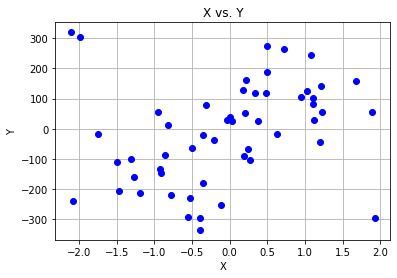

In [39]:
# reading in CSV file
outliers_train = pd.read_csv('data/outliers_train.csv', sep=",")

# EDA 1: viewing data in a table to see numerical values
display(outliers_train)
display(outliers_train.describe())

# EDA 2: plotting X and Y together as a scatter plot to see any trends
plt.figure(figsize=[6,4])
plt.plot(outliers_train['X'],outliers_train['Y'],'ob')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X vs. Y')
plt.grid(True)
plt.show()


There are 3 clear outliers. Two are in the upper left-hand corner and one is in the lower right-hand corner. 


**4.2 Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`.**



const    -9.506264
X        47.355423
dtype: float64
0.08420240965174708


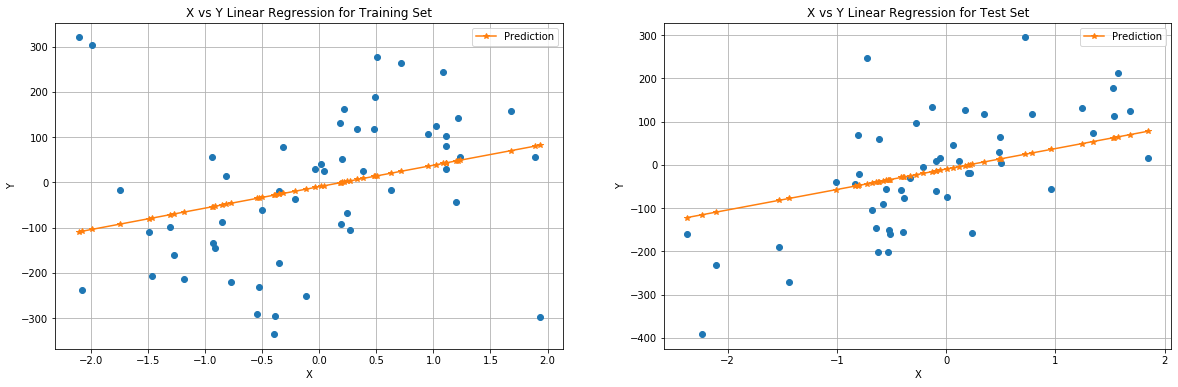

In [40]:
# reading in data as a pandas dataframe
outliers_test = pd.read_csv('data/outliers_test.csv')

# splitting data into training and testing sets manually (completed manually in statsmodel; sklearn has its own method)
x_train, y_train = outliers_train['X'], outliers_train['Y']
x_test, y_test = outliers_test['X'], outliers_test['Y']

# adding column of 1s to x train and test data (necessary step in statsmodel; automatic in sklearn)
x_train_ca = sm.add_constant(x_train)
x_test_ca = sm.add_constant(x_test)

# defining the model (using OLS as linear regression model) and verifying the result of the fit
OutlierOLSModel = sm.OLS(y_train, x_train_ca)
results = OutlierOLSModel.fit()
print(results.params)
print(results.rsquared)

# plotting the results of the linear regression on the training set in 2 instances: (1) on the training model and (2) on the testing model
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes = axes.ravel()

# training set
axes[0].plot(x_train, y_train, 'o')
axes[0].grid(True)
sorted_time = x_train.sort_values()
prediction_lr = results.predict(sm.add_constant(sorted_time))
axes[0].plot(sorted_time, prediction_lr, '*-', label = 'Prediction')
axes[0].set_title('X vs Y Linear Regression for Training Set')

# test set
axes[1].plot(x_test, y_test, 'o')
axes[1].grid(True)
sorted_time = x_test.sort_values()
prediction_lr = results.predict(sm.add_constant(sorted_time))
axes[1].plot(sorted_time, prediction_lr, '*-', label = 'Prediction')
axes[1].set_title('X vs Y Linear Regression for Test Set')

# setting up labels
for i, ax in enumerate(axes):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

**4.3 You're given the knowledge ahead of time that there are 3 outliers...Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?**
  

If you know that there are 3 outliers and you go for a brute force method, testing on every possible subset of the data with 3 points removed, you would have 50 choose 53 ways, or 23426 ways.

**4.4  Construct an approximate algorithm to find a user-specified number of outlier candidates in the training data...**

In [41]:
def find_outliers_simple(dataset_x, dataset_y, num_outliers):

    '''
    IMPLEMENTATION:
                Select the `num_outliers` most extreme residuals from the linear regression model to predict dataset_y
                from dataset_x.
    
    PARAMETERS:
                dataset_x: Features.
    
                dataset_y: Response variable stored as a numpy column vector.
    
                num_outliers: Number of outliers to remove.
                
    OUTPUTS:  
                A list `outlier_indices` representing the indices of the `num_outliers` outliers in the original 
                datasets you passed in.

    '''
    
    # verifying dataset_y is a column vector for the rest of this function
    dataset_y = np.array(dataset_y)
    
    # adding row of 1s to the column vector x
    x_train_ca = sm.add_constant((np.array(dataset_x)).reshape(-1,1))

    # defining our model
    model2 = sm.OLS(dataset_y, x_train_ca)
    results44 = model2.fit()
    
    # finding residuals
    res44 = []
    predicted44 = results44.predict()
    res44 = abs(predicted44 - dataset_y)
    
    # getting outlier indices
    outlier_indices = np.argsort(res44)[-num_outliers:]
    
    # printing the result with every call to the function for visual verification
    print('outlier_indices:', outlier_indices)
    return list(outlier_indices)

In [42]:
# applying to outliers dataset
out_ind = find_outliers_simple(outliers_train['X'], outliers_train['Y'], 3)

outlier_indices: [52 51 50]


52    1.931
51   -1.991
50   -2.110
Name: X, dtype: float64
52   -297.0
51    303.0
50    320.0
Name: Y, dtype: float64


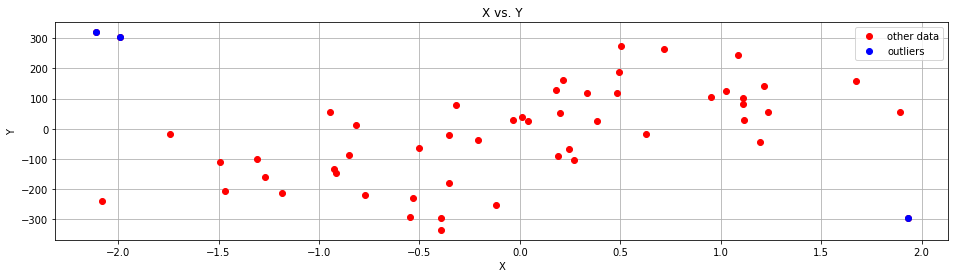

In [43]:
# quality check: verifying the indicated outliers are located as expected (upper left-hand corner and lower right-hand corner)
print(outliers_train['X'].loc[out_ind])
print(outliers_train['Y'].loc[out_ind])

# plotting the outliers and original dataset
plt.figure(figsize=[16,4])
plt.plot(outliers_train['X'],outliers_train['Y'],'ob', color = 'r', label = 'other data')
plt.plot(outliers_train['X'].loc[out_ind],outliers_train['Y'].loc[out_ind],'ob', label = 'outliers')

# labels
plt.xlabel('X')
plt.ylabel('Y')
plt.title('X vs. Y')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
# get outliers and calculate outlier model
# your code here
without_outliers_train = outliers_train.drop(out_ind)

x_train2, y_train2 = without_outliers_train['X'], without_outliers_train['Y']
#x_test, y_test = outliers_test['X'], outliers_test['Y']

#Add constant
x_train_ca2 = sm.add_constant(x_train2)

OutlierFreeSimpleModel = sm.OLS(y_train2, x_train_ca2)
results2 = OutlierFreeSimpleModel.fit()
print(results2.params)
print(results2.rsquared)

const    -17.479633
X        104.846706
dtype: float64
0.4037060455958481


**4.5 Create a figure with two subplots: the first is a scatterplot where the color of the points...**


const    -17.479633
X        104.846706
dtype: float64
0.4037060455958481
const    -9.506264
X        47.355423
dtype: float64
0.08420240965174708
const    -17.479633
X        104.846706
dtype: float64
0.4037060455958481
const    -9.506264
X        47.355423
dtype: float64
0.08420240965174708


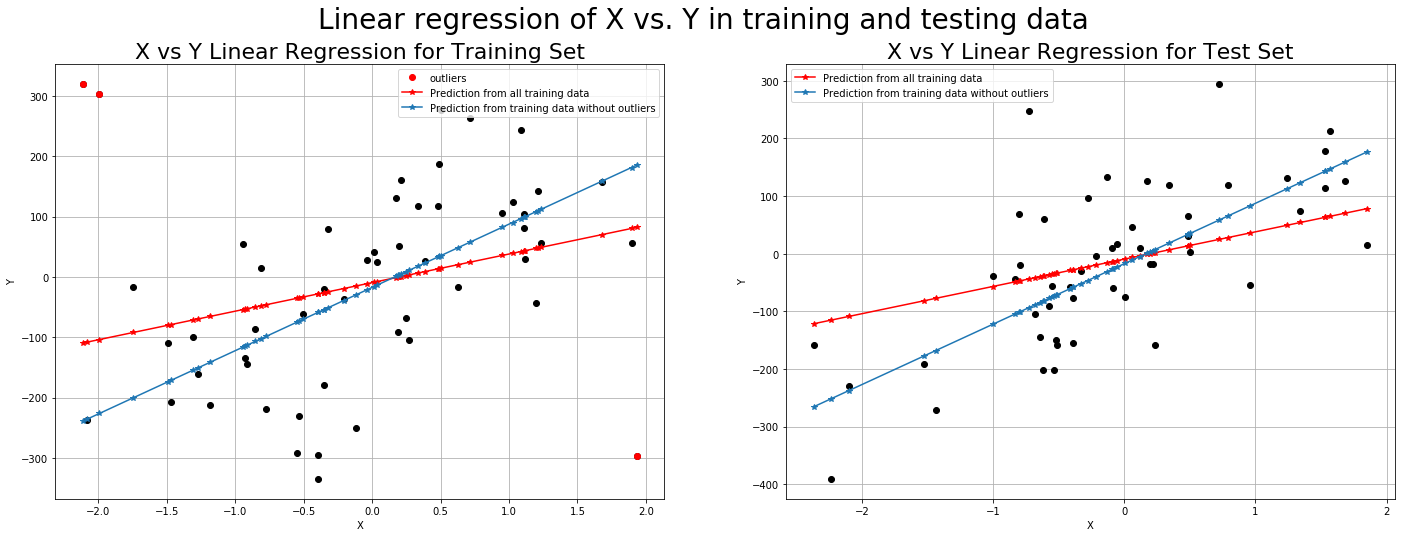

In [45]:
# plotting our model
fig, axes = plt.subplots(1,2,figsize=(24,8))
axes = axes.ravel()

# plotting the entire training dataset (outliers in red)
axes[0].plot(x_train, y_train, 'o', color='k')
axes[0].plot(outliers_train['X'].loc[out_ind],outliers_train['Y'].loc[out_ind],'o', color='r', label = 'outliers')

# finding and plotting the linear regression model in 2 ways: predicting with and without outliers
sorted_time = x_train.sort_values()
prediction_lr = results.predict(sm.add_constant(sorted_time))
axes[0].plot(sorted_time, prediction_lr, '*-', color='r', label = 'Prediction from all training data')
prediction_lr2 = results2.predict(sm.add_constant(sorted_time))
axes[0].plot(sorted_time, prediction_lr2, '*-', label = 'Prediction from training data without outliers')
axes[0].set_title('X vs Y Linear Regression for Training Set',fontsize=22)
axes[0].grid(True)

# quality check: printing parameters and r2 values
print(results2.params)
print(results2.rsquared)
print(results.params)
print(results.rsquared)

# plotting the entire testing dataset
axes[1].plot(x_test, y_test, 'o', color='k')

# finding and plotting the linear regression model in 2 ways: predicting with and without outliers
sorted_time = x_test.sort_values()
prediction_lr = results.predict(sm.add_constant(sorted_time))
axes[1].plot(sorted_time, prediction_lr, '*-', color='r', label = 'Prediction from all training data')
prediction_lr2 = results2.predict(sm.add_constant(sorted_time))
axes[1].plot(sorted_time, prediction_lr2, '*-', label = 'Prediction from training data without outliers')
axes[1].set_title('X vs Y Linear Regression for Test Set',fontsize=22)
axes[1].grid(True)

# quality check: printing parameters and r2 values
print(results2.params)
print(results2.rsquared)
print(results.params)
print(results.rsquared)

# labels
for i, ax in enumerate(axes):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
plt.suptitle('Linear regression of X vs. Y in training and testing data',fontsize=28);



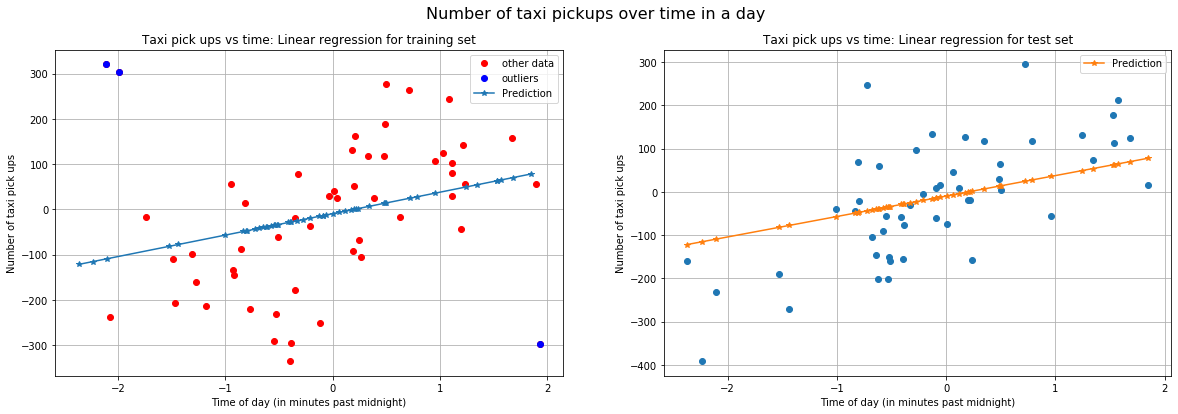

In [46]:
# Plotting our model
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes = axes.ravel()

# plotting the entire dataset (with outliers in blue)
axes[0].plot(outliers_train['X'],outliers_train['Y'],'ob', color = 'r', label = 'other data')
axes[0].plot(outliers_train['X'].loc[out_ind],outliers_train['Y'].loc[out_ind],'ob', label = 'outliers')

# plotting and defining the linear regression model
prediction_lr = results.predict(sm.add_constant(sorted_time))
axes[0].plot(sorted_time, prediction_lr, '*-', label = 'Prediction')
axes[0].set_title('Taxi pick ups vs time: Linear regression for training set')

# plotting the entire data set (sorted by X)
axes[1].plot(x_test, y_test, 'o')
sorted_time_test = outliers_test.sort_values(['X'])['X']
prediction_lr_test = results.predict(sm.add_constant(sorted_time_test))

#plotting and defining the linear regression model
axes[1].plot(sorted_time_test, prediction_lr_test, '*-', label = 'Prediction')
axes[1].set_title('Taxi pick ups vs time: Linear regression for test set')

# labels
for i, ax in enumerate(axes):
    ax.set_xlabel('Time of day (in minutes past midnight)')
    ax.set_ylabel('Number of taxi pick ups')
    ax.legend()
axes[0].grid(True)
axes[1].grid(True)
plt.suptitle('Number of taxi pickups over time in a day',fontsize=16);



By visual inspection, the linear regression made on the data sets **without** outliers creates the most fit model for linear regression. 

**4.6 Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?**


In [47]:
# WITH OUTLIERS INCLUDED

# Method 1: Step-by-step Computation
# calculating the squared error
y_pred_train = results.predict(x_train_ca)
squared_error_train = (y_pred_train - y_train)**2

# calculating the mean squared error:
error_var_train = squared_error_train.mean()
sample_var_train = ((y_train - y_train.mean())**2).mean()
y_pred_test = results.predict(x_test_ca)
squared_error_test = (y_pred_test - y_test)**2
error_var_test = squared_error_test.mean()
sample_var_test = ((y_test - y_test.mean())**2).mean()

print('Testing:', error_var_test, sample_var_test, 1 - error_var_test/sample_var_test)


# Method 2: Metrics, Performance Evaluation and Helpful Functions
from sklearn import metrics

# MSE (with test set)
print("R^2 Score for Linear Regression (Testing) :", metrics.r2_score(y_test, results.predict(x_test_ca)))

Testing: 12380.101881877297 18782.105894932054 0.34085656043405654
R^2 Score for Linear Regression (Testing) : 0.34085656043405654


In [48]:
# WITHOUT OUTLIERS

# calculating the squared error
y_pred_train = results2.predict(x_train_ca)
#print('Training R^2: ', results.rsquared)
squared_error_train = (y_pred_train - y_train)**2

# calculating the mean squared error:
error_var_train = squared_error_train.mean()
sample_var_train = ((y_train - y_train.mean())**2).mean()
y_pred_test = results2.predict(x_test_ca)
squared_error_test = (y_pred_test - y_test)**2
error_var_test = squared_error_test.mean()
sample_var_test = ((y_test - y_test.mean())**2).mean()

print('Testing:', error_var_test, sample_var_test, 1 - error_var_test/sample_var_test)

Testing: 10274.625433565707 18782.105894932054 0.4529566870167582


**4.7 One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers...**

*your answer here*

run alg from 4.4 over a range of num_outliers,  so first check model r2 if you drop 1 outlier; then if you drop 2 outliers; then if you drop 3 outliers; etc. until you have as many outliers as you want to try.  plot improvement in r2 and see when you have biggest improvement.  could also check improvement in MSE because ??

**Hints**:
   1. Should outliers be removed one at a time or in batches?
   2. What metric would you use and how would you use it to determine how many outliers to consider removing?

In [49]:
# in the testing set, where does r2 or mse improve the most? avoiding overfitting by havign a training and testing set byt you don't even need to use the training set


#want to drop one at a time because the things you decide to be outliers need to be based on new linear regression model...2nd outlier might be diff once you have refit to the outlier free model
